In [1]:
import autograd.numpy as np
from autograd import grad, jacobian, elementwise_grad
import matplotlib.pyplot as plt
import math

#位置エネルギー　とその微分（対数ターゲット分布：後で定義する)
log_prob=None
d_log_prob=None

# 運動エネルギー(対数ガウス分布)とその微分
def momentum(p):
    return  -np.sum(p**2)
d_momentum=jacobian(momentum)

#ハミルトニアン（https://arxiv.org/pdf/1701.02434.pdfの解説でいうlevel setだったりエネルギーEだったり ）
def H(q,p):
    return log_prob(q)+momentum(p)

epsilon=0.5
# リープ・フロッグ法を実行する関数
def leapflog( q,p ):
    q=np.copy(q)
    p=np.copy(p)
    q += -0.5*epsilon*(d_momentum(p))
    p += epsilon*d_log_prob(q,)
    q += -epsilon*(d_momentum(p))
    return q, p

#leapFrogの軌道をつくるモデルパラメータqが指定されてなければ、乱数で作る＝新しいchainの開始
#qが指定されていればそれを引き継いでモーメンタム項だけを乱数サンプリング
L=20 #軌道の長さ（HMCのstep数)
ORDER=2
def make_traj(q=None,p_org=None):
    #qの初期値は適当にやる（chainの最初の一点なので確率０でなければ良い)
    #初期段階以外は、qは前回の続き
    if(q is None):q=np.random.randn(ORDER) 
    qs=[q]
    #pのサンプリングはギブスサンプリング風
    #exp(momentum(p))の確立分布でpをサンプリング⇒ガウス関数なのでそのままrandnを使う
    p=np.random.randn(ORDER)
    ps=[p]    
    for i in range(L):
        q,p=leapflog(q,p)
        qs.append(q)
        ps.append(p)
    ps=np.array(ps)
    qs=np.array(qs)
    #qのサンプリングは、pの候補が確定したと考えた後のMH法によるサンプリングなので
    #exp(H(q,p))の確率を、遷移前・遷移後で比較する
    rate=H(qs[-1],ps[-1])-H(qs[0],ps[0])
    
    if (0<rate) or (np.random.rand(1)< math.exp(rate)): 
        return qs,ps,True
    else:        
        #print("MH reject retry the trajctory : from,to = ",H(qs[0],ps[0]),H(qs[-1],ps[-1]))
        qs=np.ones((L+1,ORDER))*qs[0] #遷移出来なかったので、軌道もない　行列サイズを合わせるため 同じ内容でpadding
        if(p_org is None):p_org=ps[0]
        ps=np.ones((L+1,ORDER))*p_org
        return qs,ps,False

nof_sample=50    #軌道を何本えがくか、（軌道の最後1個の値をサンプルするのが普通のHMC (stanのNUSではHで補正した一様分布で軌道の中から選ぶ))
def make_chain():
    q=None
    p=None
    ret=[]
    skip_count=0;
    for i in range(nof_sample):
        qs,ps,result=make_traj(q,p)
        if(False is result): skip_count+=1
        ret.append([qs,ps])
        q=np.copy(qs[-1])
        p=np.copy(ps[-1])
    print("Number of MH reject:",skip_count)
    return ret
#補足:
#make_chainが exp(H(q,p))=exp(log_prob(q) + momentum(p))の確率分布からサンプリングしている
#そのサンプリング方法が、局所的にはメトロポリス・ヘイスティングス(MH)法とギブスサンプリングのハイブリッドになっている。
#
#1.現時点をパラメータ(p,q)であるとする、
#2.momentumパラメータpをギブスサンプリング同様に独立にq'に更新、次ぎにH(q,p')≒H(q',p')となるq'をleapfrogで求める
#3.(今回のプログラムでは省略) exp(H(q,p'))とexp(H(q',p'))を比較して遷移するか否かを確率的に決定。
#　このときH(q,p)=H(q',p')のとき必ず遷移できる。遷移拒否がおきるとサンプリング作業がp'選ぶ所からやり直しになるぶんサンプリング遅い


#補足の補足:メトロポリス・ヘイスティング法(MH法)
#MCMCの一種、有るパラメータθについて、θをθ'に遷移させる事を考える
#p(θ→θ')をθからθ'に遷移する確率として、
# p(θ→θ')p(θ)=p(θ→θ')p(θ)
#が成り立つように遷移確率を設定して適当に候補θ'を提案し続ければ、遷移の度に拾った値θが
#p(θ)

#補足の補足：ギブスサンプリング
# パラメータq,pがある確率密度関数H(q,p)があるとき、仮にqを適当な値に固定して
# pの分布の確率密度関数を作れるのならば、パラメータを一つずつサンプリングして更新すれば良いというもの
# 上の例だとH(p,q)をlog_prob(q)+momentum(p)という形でq,pは独立なので、どんなqに固定しても
# pをサンプリングする確率密度関数はexp(mementum(p))になる



#モデル関数：ガウス分布
def log_prob_normal(q):
    global M
    return -np.sum(np.dot(np.dot(q,M),q))
#モデル関数：裾が重い分布(exp(-|x|))
def log_prob_exp(q):
    global M
    return -np.sum( np.sqrt(np.dot(np.dot(q,M),q)))
#モデル関数：より裾が重い分布(exp(-|x|**0.25))
def log_prob_heavy(q):
    global M
    return -np.sum( (np.dot(np.dot(q,M),q))**0.125 )


##プロット要関数###

def plot(ret,s_alpha,l_alpha):
    #モデルパラメータqをプロット
    aret=np.array(ret,dtype=np.float)
    qsize=aret[:,0,:].max()
    plt.figure(figsize=(10,10))
    plt.title("q: paramter")
    plt.xlim([-qsize,qsize])
    plt.ylim([-qsize,qsize])
    for qs,ps in ret:
        plt.plot(qs[:,0],qs[:,1],alpha=l_alpha)
        plt.scatter(qs[-1,0],qs[-1,1],marker="x",alpha=s_alpha)
    plt.show()

    #モーメンタム項pをプロット
    psize=aret[:,1,:].max()
    plt.figure(figsize=(10,10))
    plt.title("p: momentam")
    plt.xlim([-psize,psize])
    plt.ylim([-psize,psize])
    for qs,ps in ret:
        plt.plot(ps[:,0],ps[:,1],alpha=l_alpha)
        plt.scatter(ps[-1,0],ps[-1,1],marker="x",alpha=s_alpha)
    plt.show()

    #E-BFMI指標となる (E(n)-E(n-1)) とE-mean(E)のヒストグラムをプロット
    #https://arxiv.org/pdf/1701.02434.pdf のP45. Fig.34を作るのとほぼ同じはず。
    #モデルが_normalのときはほぼ一致、_expのときは乖離するのが観察できる
    #モデルの線形な歪み(M)は影響しないっぽい
    p_end=  aret[:,1,-1,:]
    q_end=  aret[:,0,-1,:]
    H_end=  np.array([H(q,p) for q,p in zip(q_end,p_end)],dtype=np.float)

    plt.figure(figsize=(10,10))
    plt.title("q-H plot")

    h_m=H_end-np.mean(H_end)
    hd=H_end[1:]-H_end[:-1]
    hd_m=hd-np.mean(hd)
    print("E-BFMI",np.sum(hd_m**2)/np.sum(h_m**2) )    
    plt.hist([h_m,hd_m],label=["H mean","H_diff mean(~p(H|q))"])
    plt.legend()



# HMCの軌道とサンプル点の例

Number of MH reject: 4


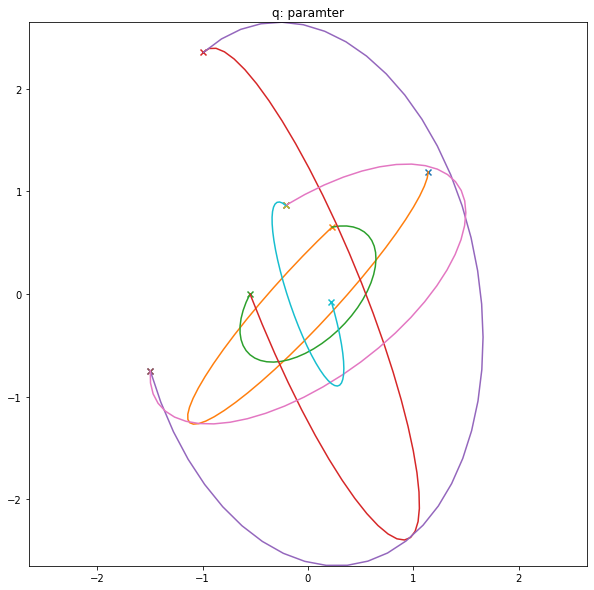

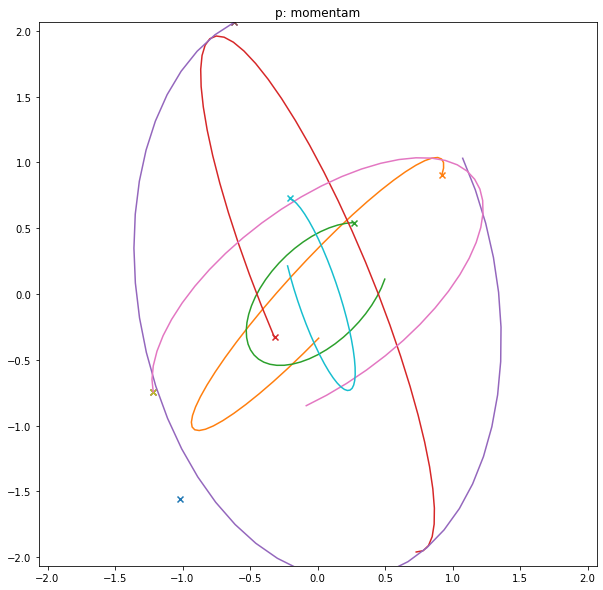

E-BFMI 1.1897319417685266


D:\Users\akira\Anaconda3\envs\stan\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


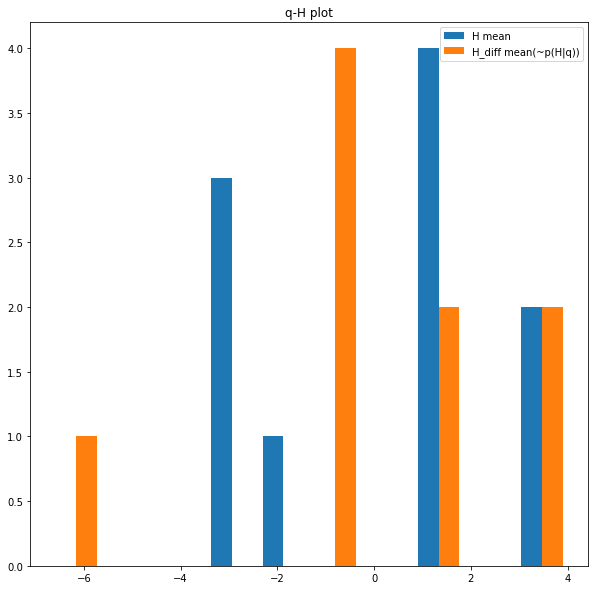

In [2]:
log_prob=log_prob_normal #ここでモデル関数を選ぶ
d_log_prob= jacobian(log_prob)

#モデル関数の分布を歪ませるためのマトリックス
M=np.array([[1,0],[0,1]])#綺麗に分布している例
#M=np.array([[3,0],[0,0.3]])#スケールがパラメータ間で違う例
#M=np.array([[1,0.99],[0.99,1]])#パラメータ間相関が高い例

#HMC実行

L=40
epsilon=0.05
nof_sample=10
ret=make_chain()
plot(ret,1,1)

## 実用的なセッティングでの例
- MH rejectの率って0.2(受け入れ率 0.8)位 を目指す
- 軌道の長さは、入力と位相の相関がない位が理想だけど、伝統的HMCは一定長さを設定するので割と運しだい

結論:**実用的なセッティングではステップサイズが大きくてカクカクした軌道を使うけど、見づらいので過剰に小さなステップサイズで図をつくる**

Number of MH reject: 6


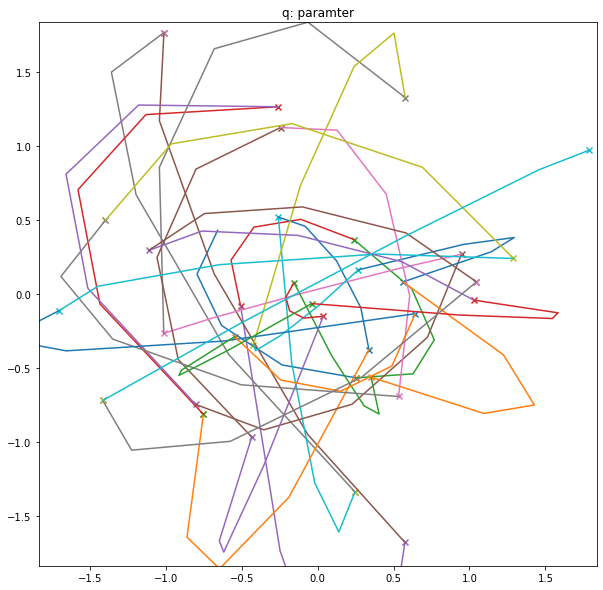

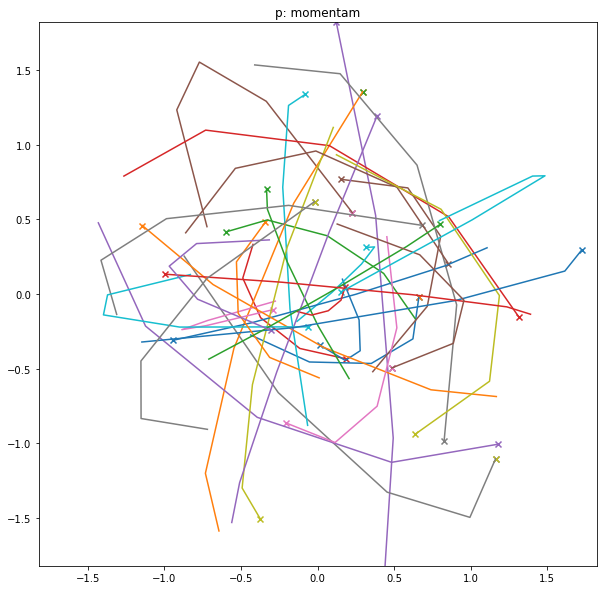

E-BFMI 1.168867369240048


D:\Users\akira\Anaconda3\envs\stan\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


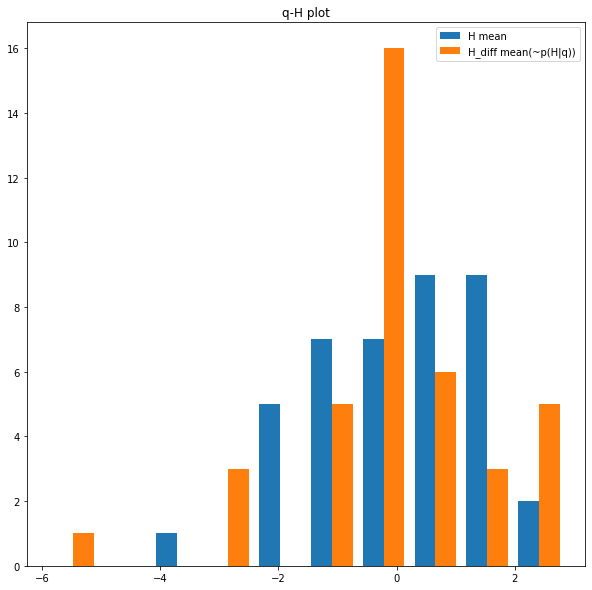

In [3]:
log_prob=log_prob_normal #ここでモデル関数を選ぶ
d_log_prob= jacobian(log_prob)

#モデル関数の分布を歪ませるためのマトリックス
M=np.array([[1,0],[0,1]])#綺麗に分布している例

L=4
epsilon=0.25
nof_sample=40 #nof_sample40に対して　rejectが8ぐらいおきればOK
ret=make_chain()
plot(ret,1,1)

# 十二分に長い軌道にして、軌道の動きを観察
## 普通のガウス分布（正規分布）の場合
モーメンタム項で軌道をえらんで、その軌道の中を一定量進む事でパラメータqをサンプリングしている。  
古いタイプのHMCは最終ステップを採用するけれども、新しいHMCは軌道の中からランダムに選ぶ

Number of MH reject: 2


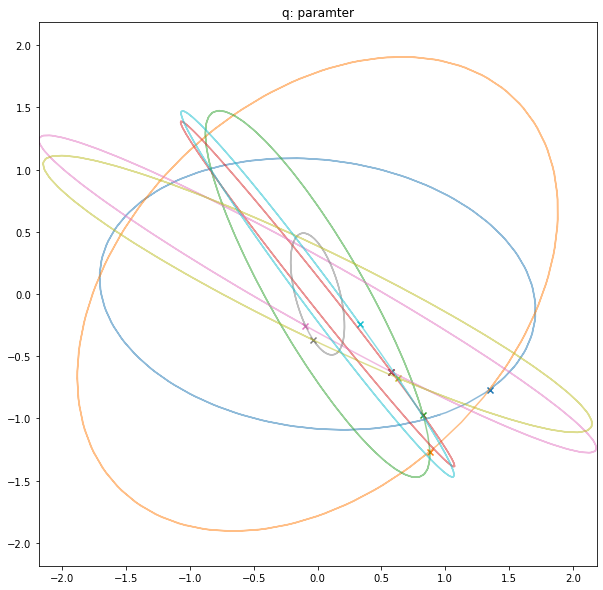

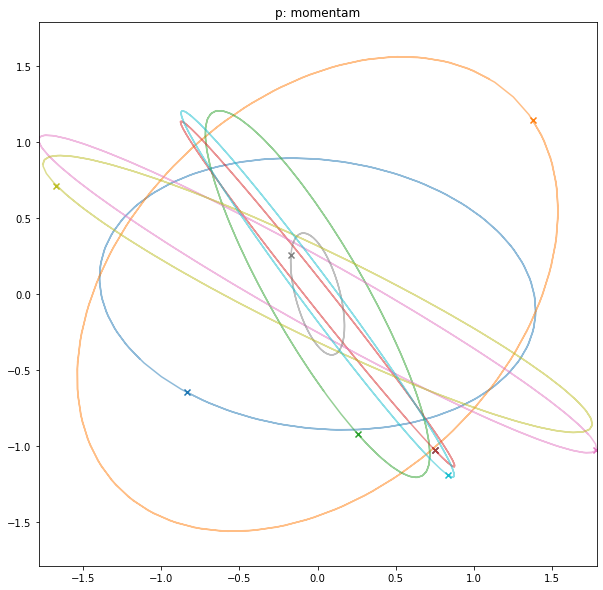

E-BFMI 2.6784971215001945


D:\Users\akira\Anaconda3\envs\stan\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


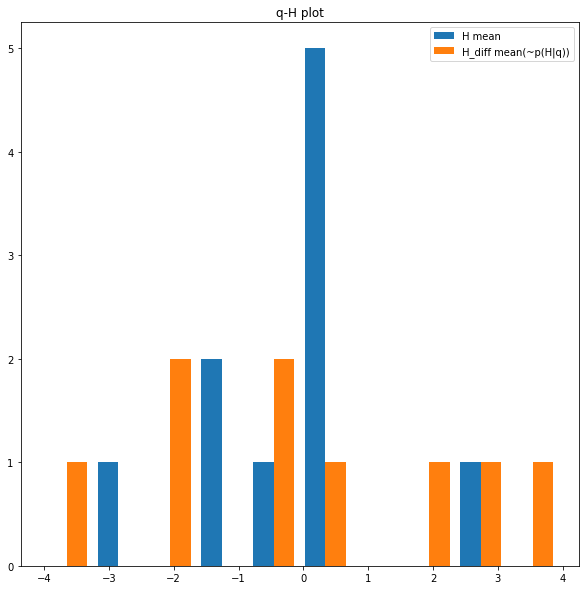

In [4]:
epsilon=0.05

log_prob=log_prob_normal #ここでモデル関数を選ぶ
d_log_prob= jacobian(log_prob)

#モデル関数の分布を歪ませるためのマトリックス
M=np.array([[1,0],[0,1]])#綺麗に分布している例

#HMC実行
L=100
nof_sample=10
ret=make_chain()
plot(ret,1,0.5)


# 裾が重い場合

Number of MH reject: 3


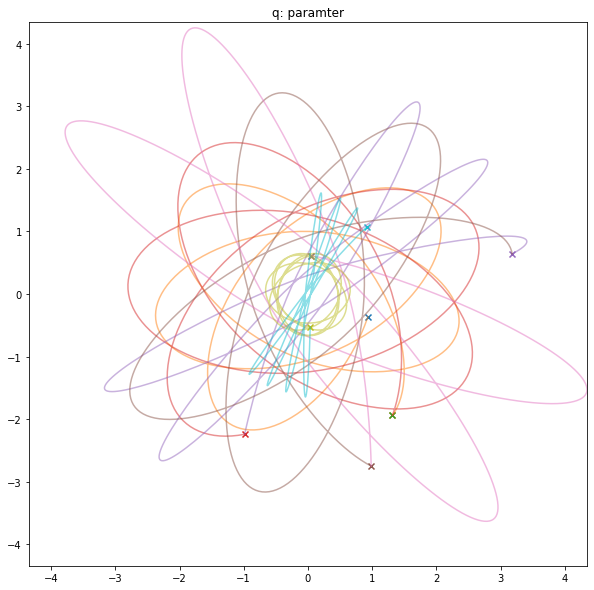

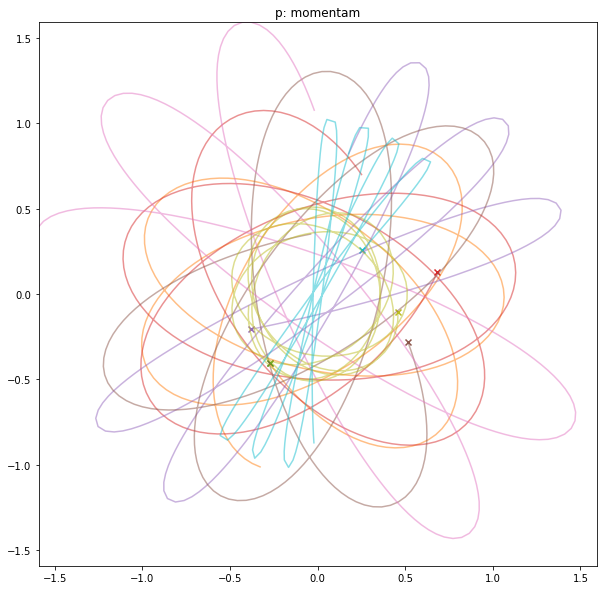

E-BFMI 1.0494610520349015


D:\Users\akira\Anaconda3\envs\stan\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


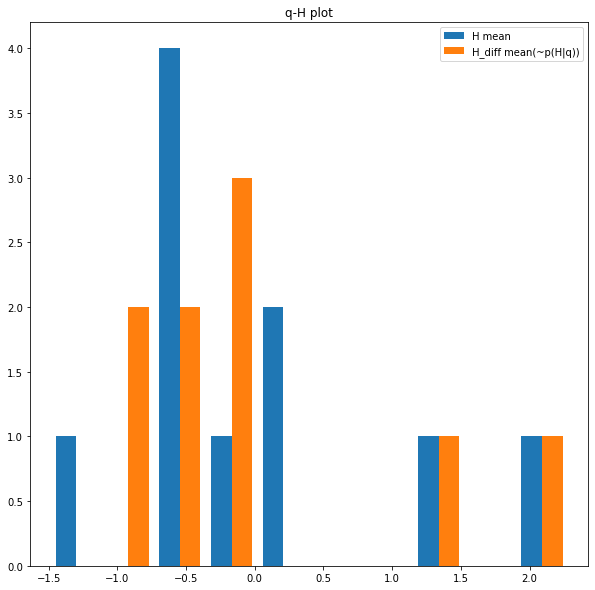

In [5]:
log_prob=log_prob_exp #ここでモデル関数を選ぶ
d_log_prob= jacobian(log_prob)

#モデル関数の分布を歪ませるためのマトリックス
M=np.array([[1,0],[0,1]])#綺麗に分布している例

#HMC実行
L=300
nof_sample=10
ret=make_chain()
plot(ret,1,0.5)


# 歪んだガウス分布の場合

Number of MH reject: 2


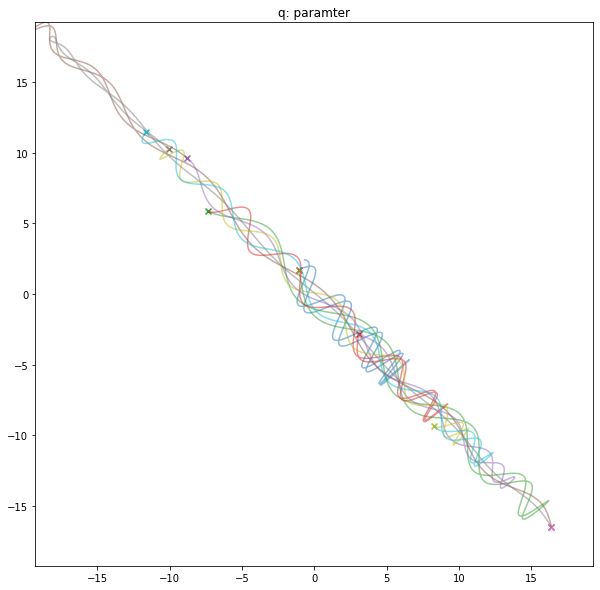

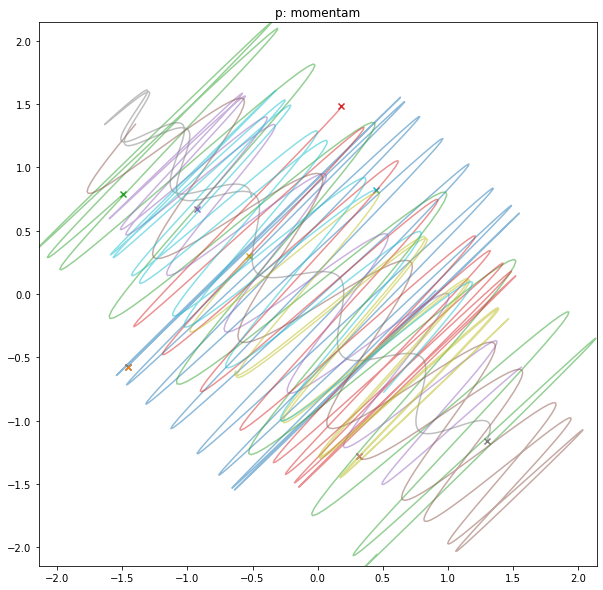

E-BFMI 1.4347730530147804


D:\Users\akira\Anaconda3\envs\stan\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


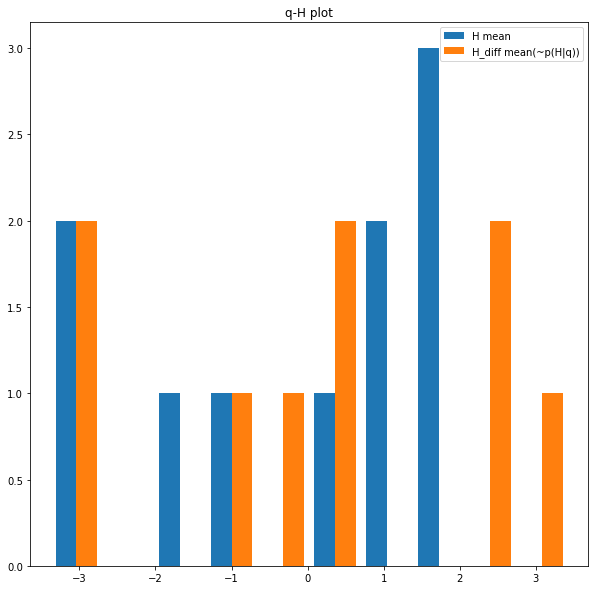

In [6]:
L=300

log_prob=log_prob_normal #ここでモデル関数を選ぶ
d_log_prob= jacobian(log_prob)

#モデル関数の分布を歪ませるためのマトリックス
#M=np.array([[1,0],[0,1]])#綺麗に分布している例
#M=np.array([[3,0],[0,0.3]])#スケールがパラメータ間で違う例
M=np.array([[1,0.99],[0.99,1]])#パラメータ間相関が高い例

#HMC実行
nof_sample=10
ret=make_chain()
plot(ret,1,0.5)

# 軌道を程よい長さに戻して、サンプル点群とエネルギの観察
- モーメンタム項の軌道は大きく変わるが、分布自体はガウス分布に近い形を保っているの
- E-BFMIのもとなるエネルギーの分布　裾野の重い分布では分布が乖離してきている

## ガウスの場合

Number of MH reject: 114


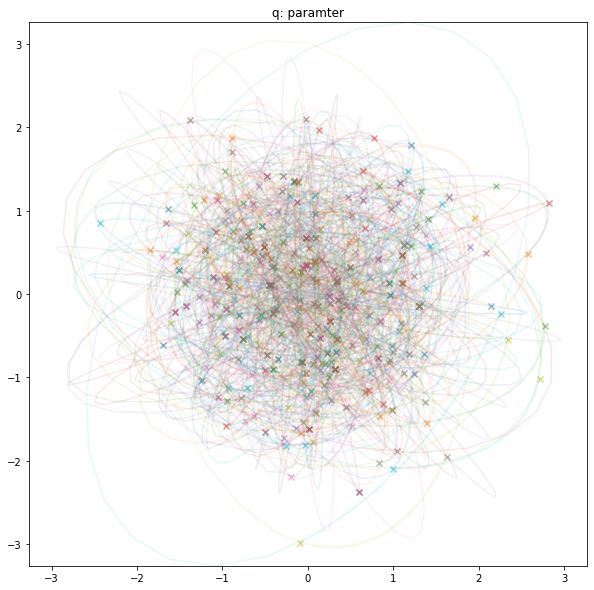

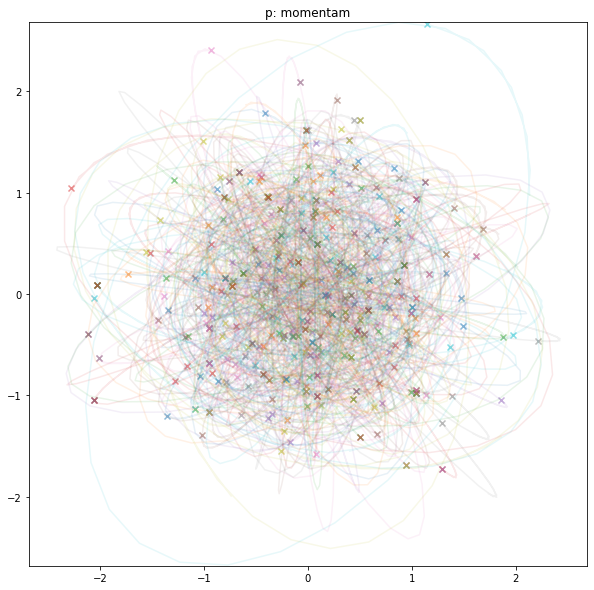

E-BFMI 0.7307671154002419


D:\Users\akira\Anaconda3\envs\stan\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


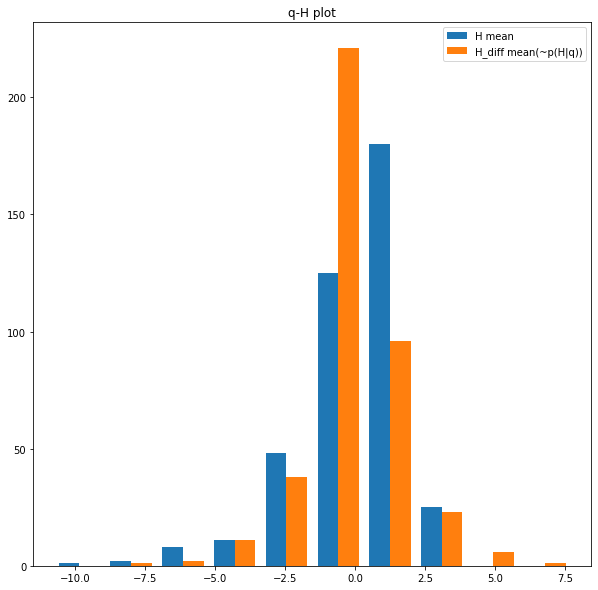

In [7]:
L=30
epsilon=0.1
nof_sample=400

log_prob=log_prob_normal #ここでモデル関数を選ぶ
d_log_prob= jacobian(log_prob)

#モデル関数の分布を歪ませるためのマトリックス
M=np.array([[1,0],[0,1]])#綺麗に分布している例

#HMC実行
ret=make_chain()
plot(ret,0.5,0.1)


## 裾の重い分布の場合
エネルギーヒストグラムに乖離が有るので、サンプリング効率が悪いパタン。  
本来探索すべきH(q,p)分布のよりも、一回の遷移で移動できた分布(H_diff)が狭いので、H(q,p)の端っこに行く確率が低くてサンプリングされにくいことを示している。  
E-BFMI(H_diffとHの分散の比)が0.3 (stanのマニュアルでは0.2)以下のときは、そもそもまともにサンプリングできてない可能性を指摘している


Number of MH reject: 114


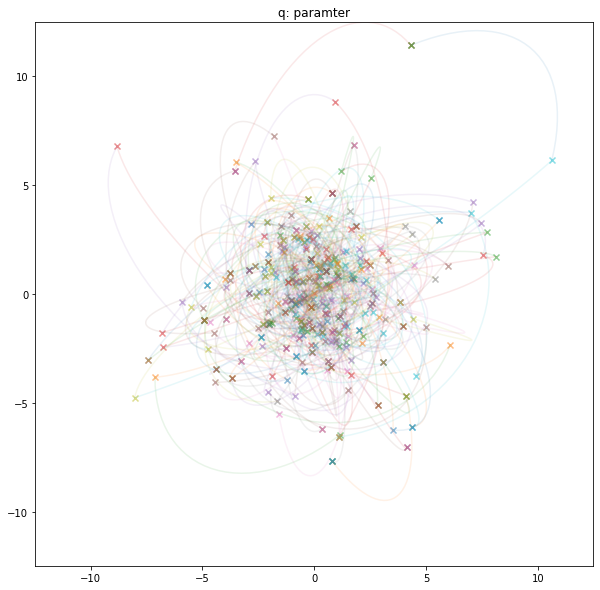

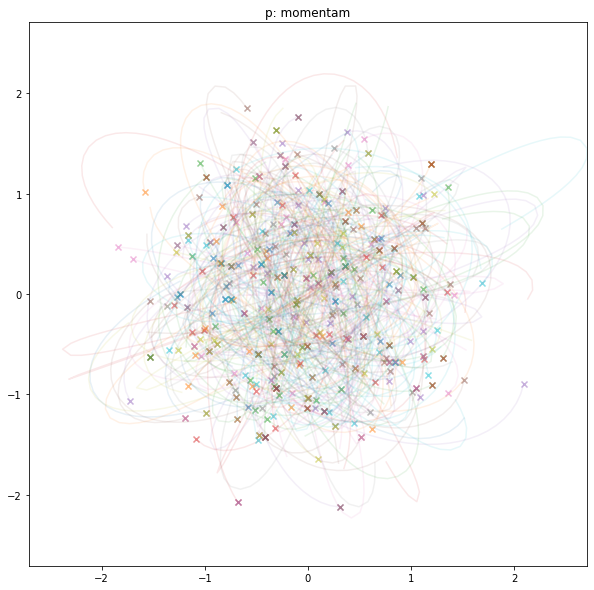

E-BFMI 0.3356901611635949


D:\Users\akira\Anaconda3\envs\stan\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


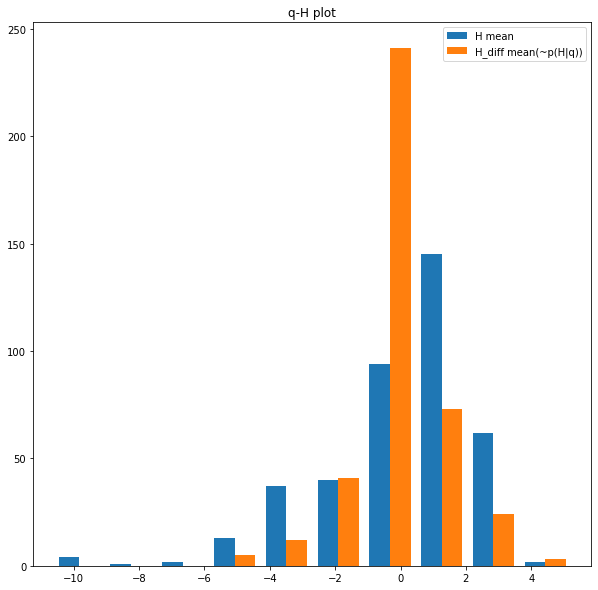

In [8]:
L=30
epsilon=0.1
nof_sample=400


log_prob=log_prob_exp #ここでモデル関数を選ぶ
d_log_prob= jacobian(log_prob)

#モデル関数の分布を歪ませるためのマトリックス
M=np.array([[1,0],[0,1]])#綺麗に分布している例

#HMC実行
ret=make_chain()
plot(ret,0.5,0.1)

## パラメータ間相関があるもの
モーメンタム項の軌道が斜めに長くなっているせいで、曲率がデカくなっている。すなわちLeapFrogでの誤差が大きくなりがち。

Number of MH reject: 83


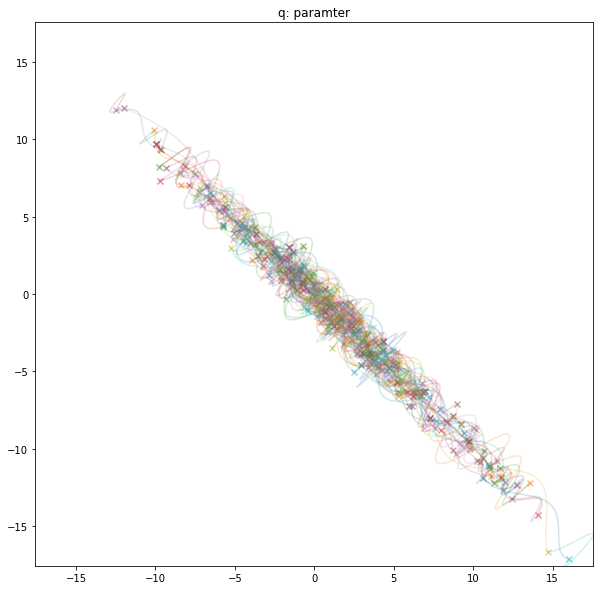

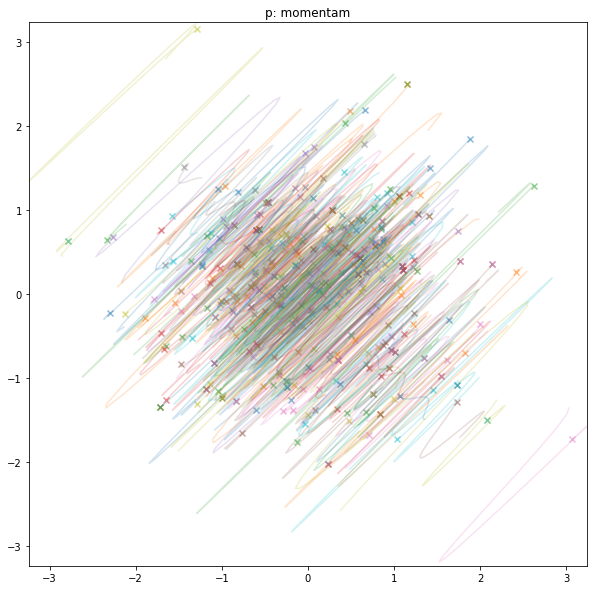

E-BFMI 1.133603273302274


D:\Users\akira\Anaconda3\envs\stan\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


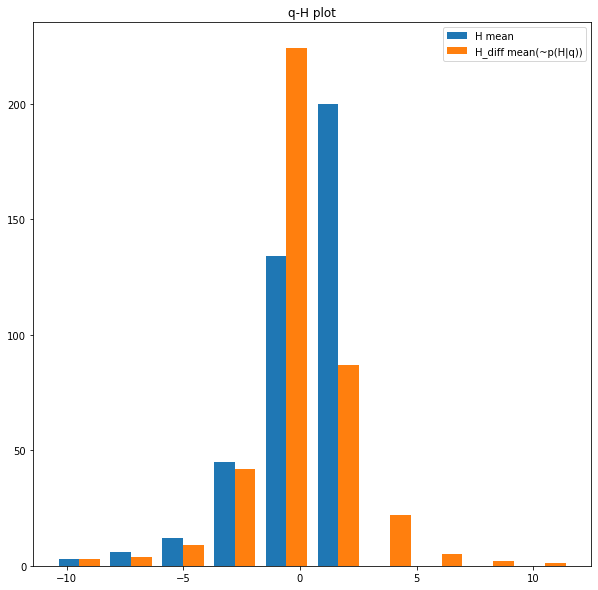

In [9]:
L=20
epsilon=0.1
nof_sample=400


log_prob=log_prob_normal #ここでモデル関数を選ぶ
d_log_prob= jacobian(log_prob)

#モデル関数の分布を歪ませるためのマトリックス
M=np.array([[1,0.99],[0.99,1]])#パラメータ間相関が高い例

#HMC実行
ret=make_chain()
plot(ret,0.5,0.2)

# E-BFMIが0.2を切るぐらい重い裾の例
- 前半：軌道確認のための少量サンプル
- 後半：分布を確認するための多量サンプルでのデータ


Number of MH reject: 17


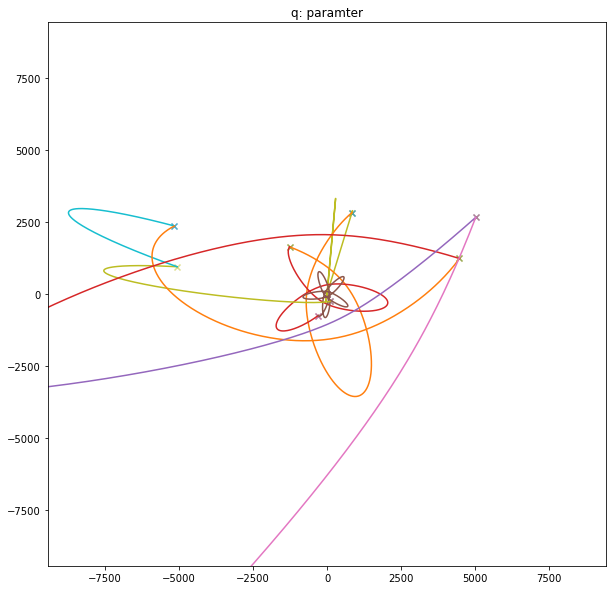

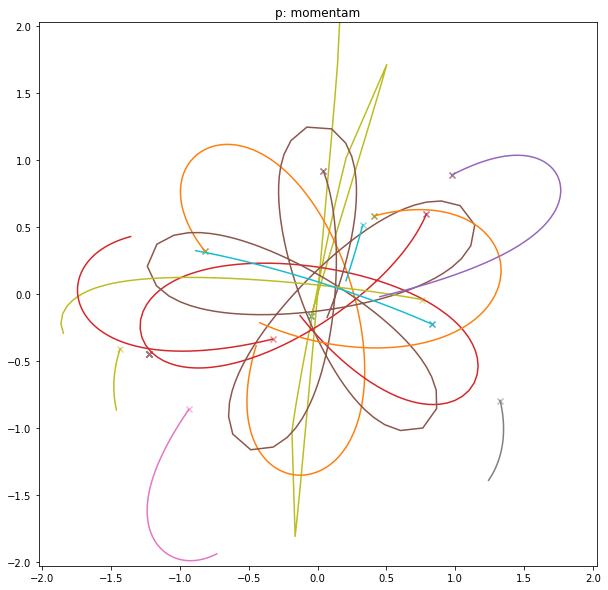

E-BFMI 0.1315869420439878


D:\Users\akira\Anaconda3\envs\stan\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


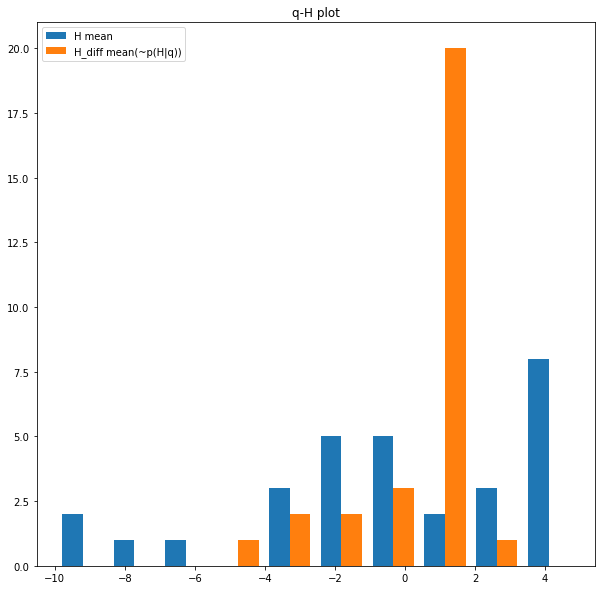

In [22]:
#裾がすごい重い場合はstep数を大きくしないと、モーメンタム項の軌道が全然動かない、パラメータ項もあまり動かない
#厳密には確率密度が高い(0,0)点付近では十分に軌道が動くが、それ以外の点だと軌道がのびない
#この確率密度が低いところでstep数が極端に必要になるのがstanのNUTSでmax_treeの大きさが足りなくなる一因でもある。
L=300  
epsilon=20 #epsilonがデカイ数になるが軌道がカクカクするわけじゃないし、Rejectレート的にも問題無い(ただし、初期値によっては全然すすまない)
nof_sample=30

log_prob=log_prob_heavy #ここでモデル関数を選ぶ
d_log_prob= jacobian(log_prob)

#モデル関数の分布を歪ませるためのマトリックス
M=np.array([[1,0],[0,1]])#綺麗に分布している例

#HMC実行
ret=make_chain()
plot(ret,0.5,1)

Number of MH reject: 117


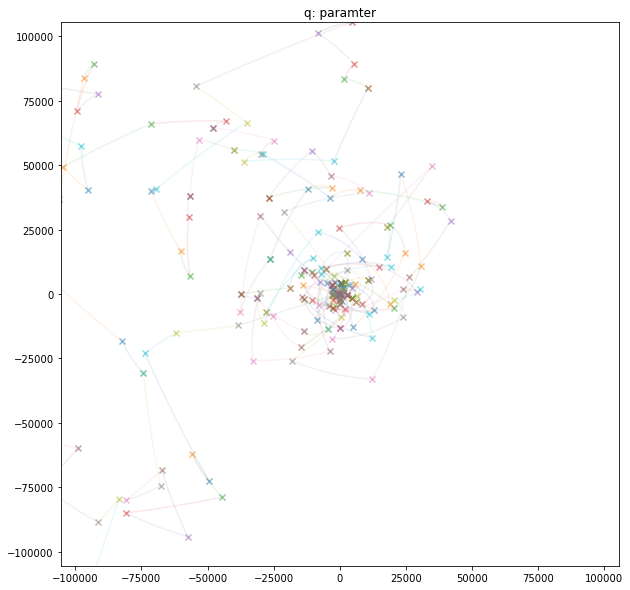

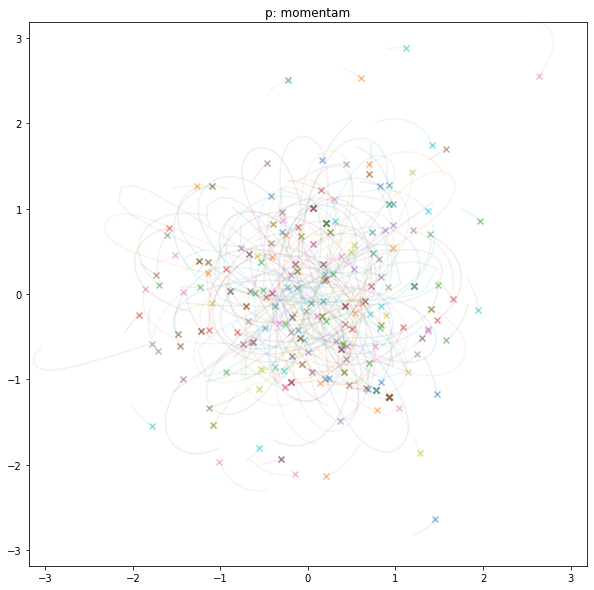

E-BFMI 0.17730741054147992


D:\Users\akira\Anaconda3\envs\stan\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


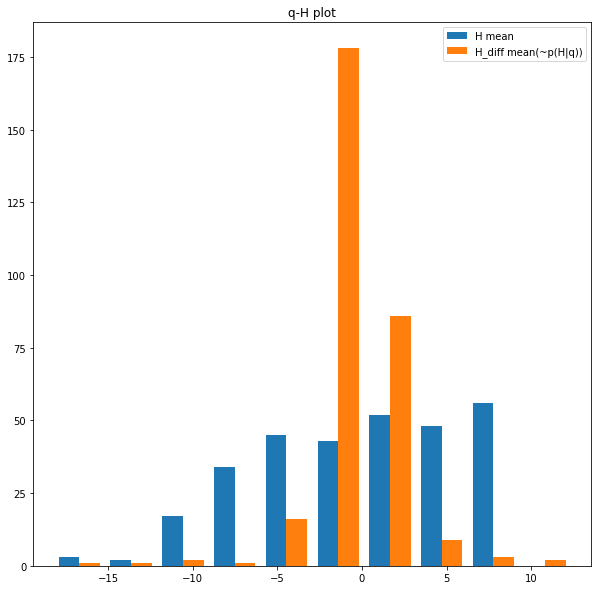

In [23]:
nof_sample=300

log_prob=log_prob_heavy #ここでモデル関数を選ぶ
d_log_prob= jacobian(log_prob)

#モデル関数の分布を歪ませるためのマトリックス
M=np.array([[1,0],[0,1]])#綺麗に分布している例

#HMC実行
ret=make_chain()
plot(ret,0.5,0.1)